# 모듈 로드

In [1]:
import numpy as np
import pandas as pd
import warnings
import gc
from tqdm import tqdm_notebook as tqdm
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.metrics import roc_auc_score
warnings.filterwarnings("ignore")
gc.enable()

In [2]:
pd.set_option('max_rows', 500)
pd.set_option('max_colwidth', 500)
pd.set_option('max_columns', 500)

# 데이터 로드

## 훈련데이터

In [3]:
train_raw = pd.read_csv('./data/train.csv')
test_raw = pd.read_csv('./data/test.csv')
train_raw.shape, test_raw.shape

((200000, 202), (200000, 201))

In [4]:
# del train, test, clf, data
# gc.collect()

In [5]:
train = train_raw.copy()
test = test_raw.copy()

In [6]:
col_list = train.columns[2:]

In [7]:
train_0 = train[train.target == 0]
train_1 = train[train.target == 1]

In [8]:
pb_idx = np.load('./data_temp/public_LB.npy')
pv_idx = np.load('./data_temp/private_LB.npy')

In [9]:
test_pb = test.iloc[pb_idx].sort_index().copy()
test_pv = test.iloc[pv_idx].sort_index().copy()

test_real = test_pb.append(test_pv)

In [10]:
data = train.append(test_real)[['ID_code', 'target'] + col_list.tolist()]

showing var_0 ~ var_3


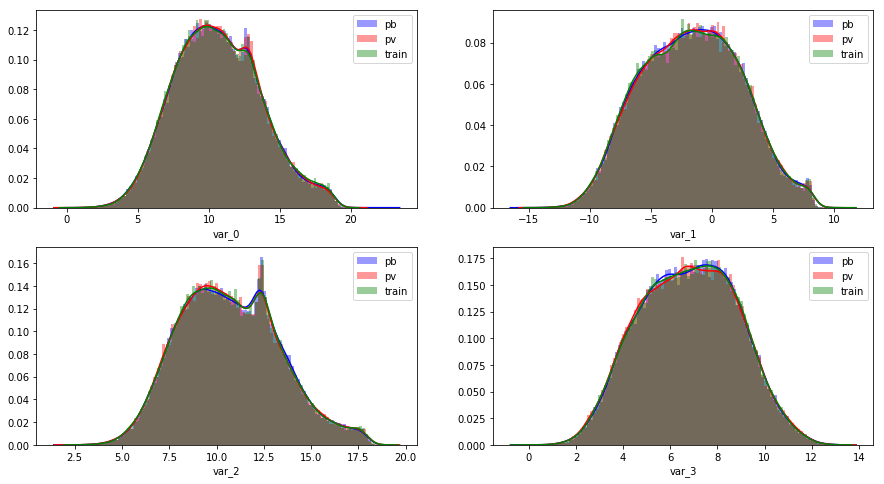

showing var_4 ~ var_7


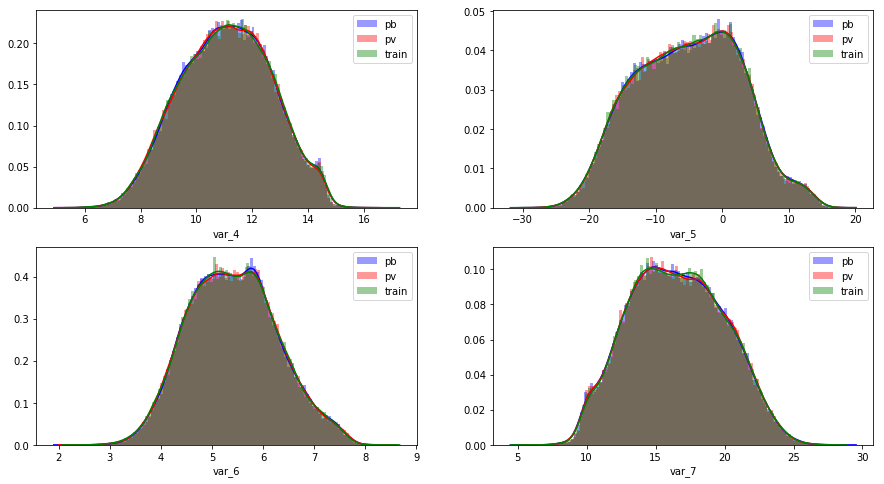

showing var_8 ~ var_11


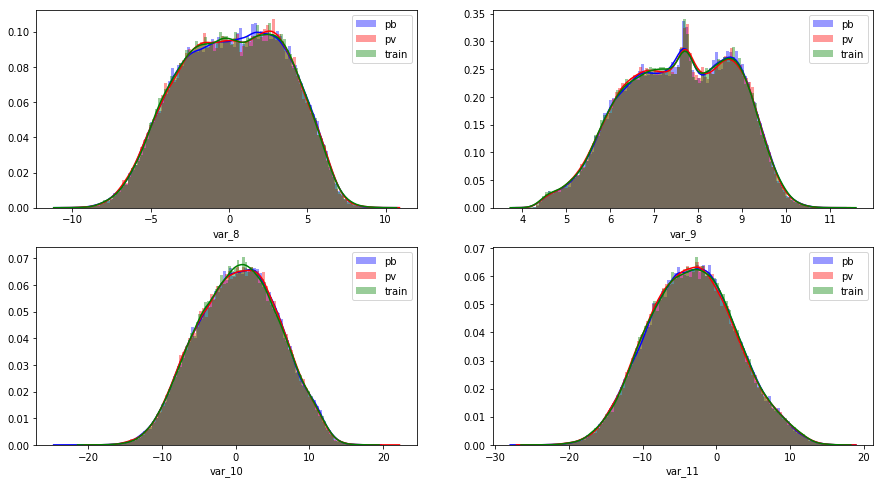

showing var_12 ~ var_15


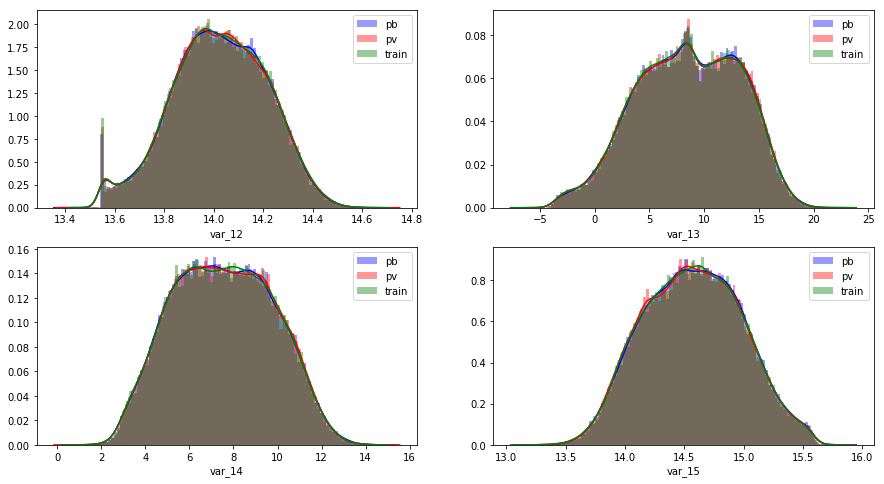

showing var_16 ~ var_19


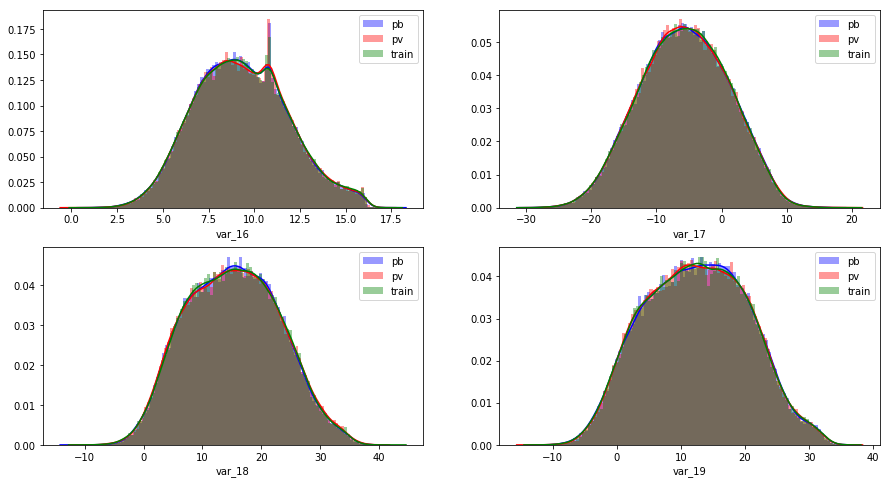

showing var_20 ~ var_23


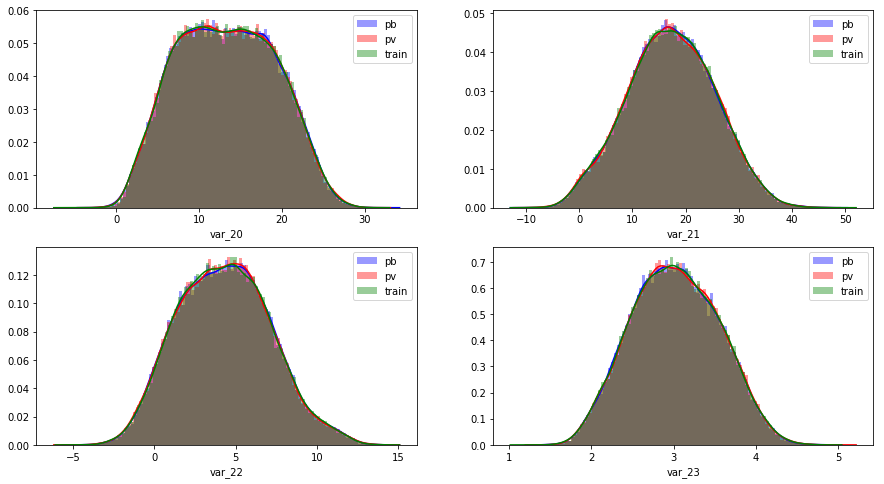

showing var_24 ~ var_27


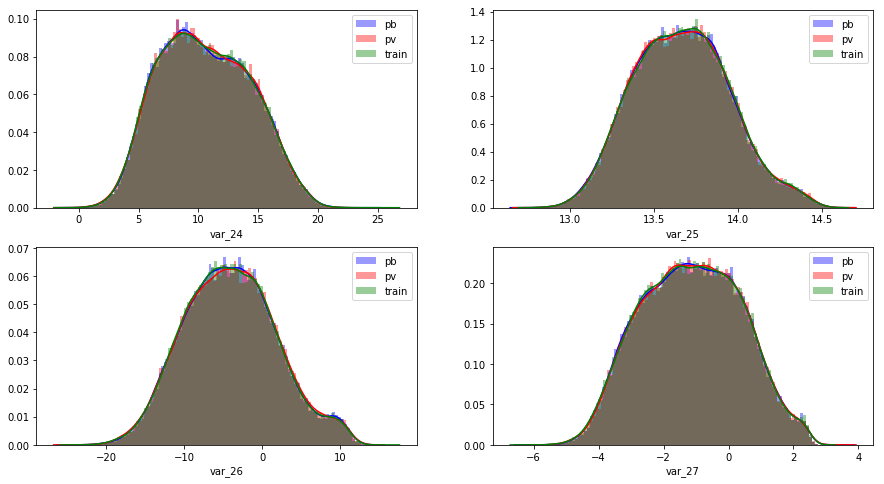

showing var_28 ~ var_31


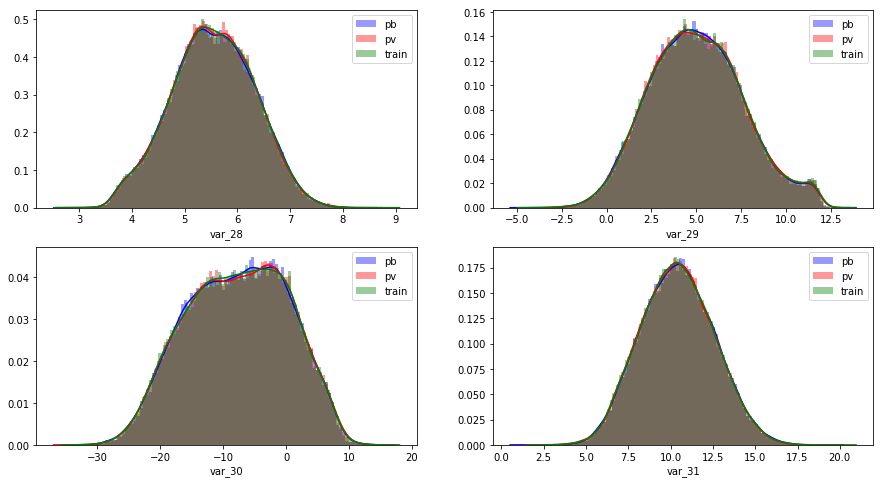

showing var_32 ~ var_35


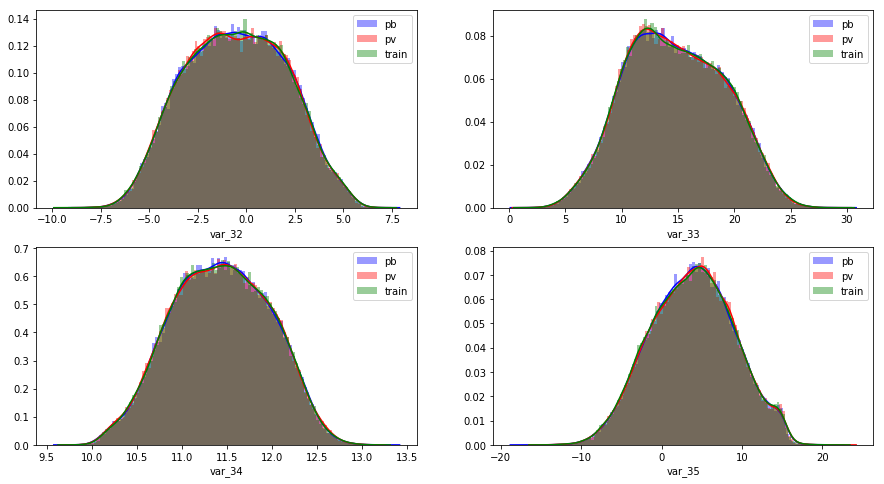

showing var_36 ~ var_39


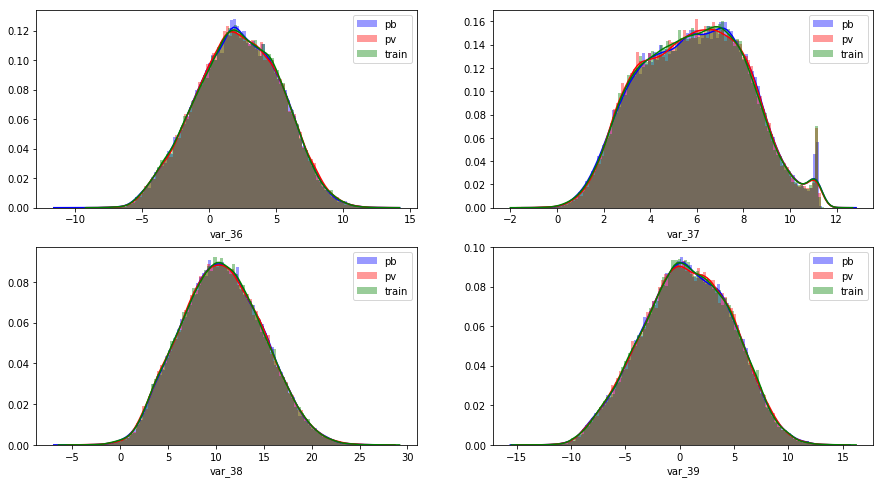

showing var_40 ~ var_43


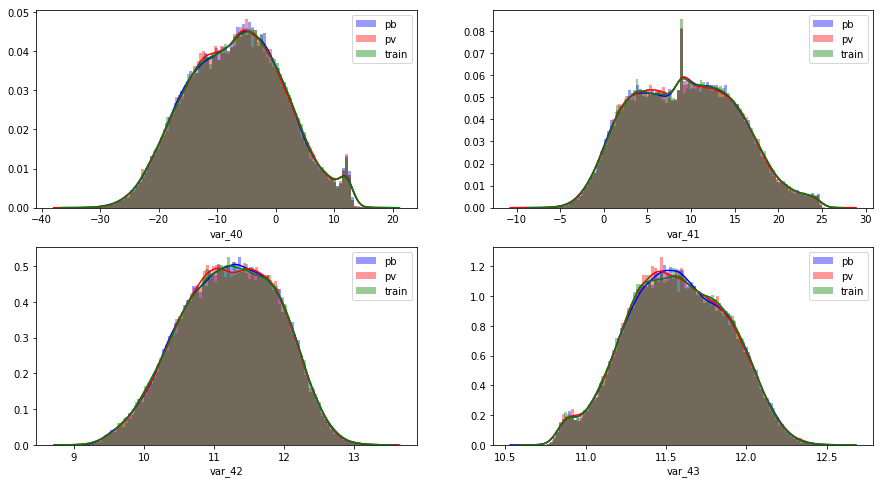

showing var_44 ~ var_47


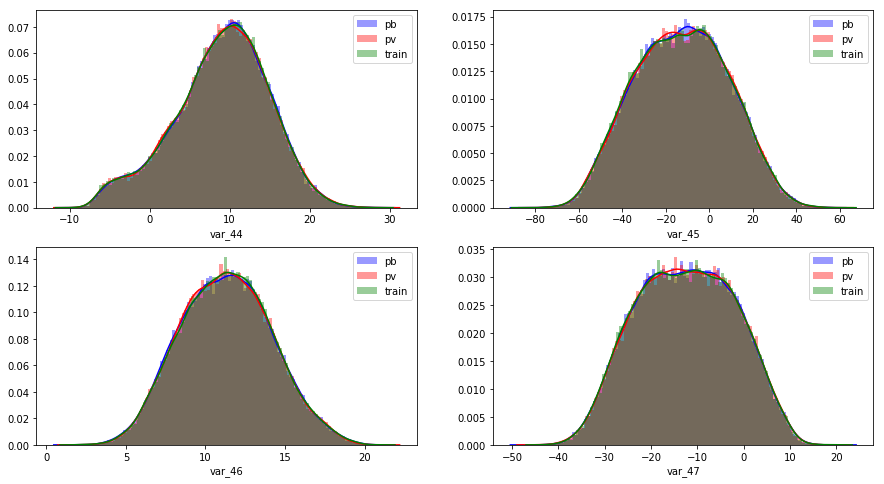

showing var_48 ~ var_51


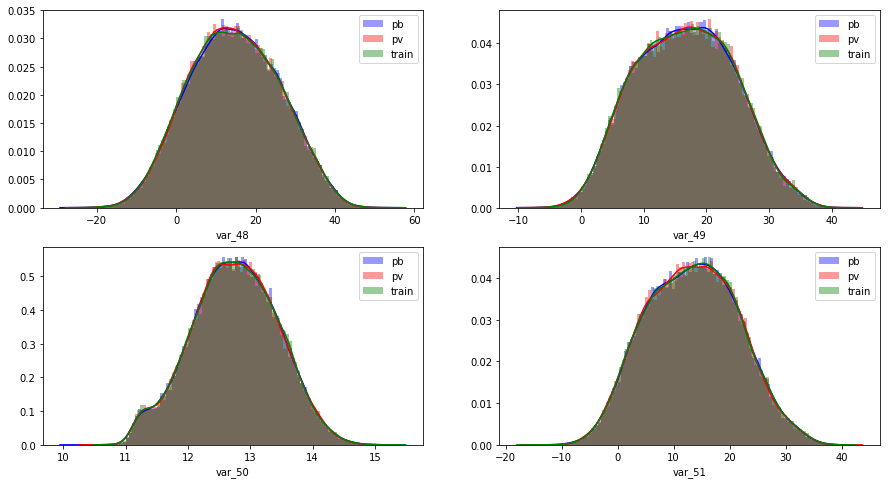

showing var_52 ~ var_55


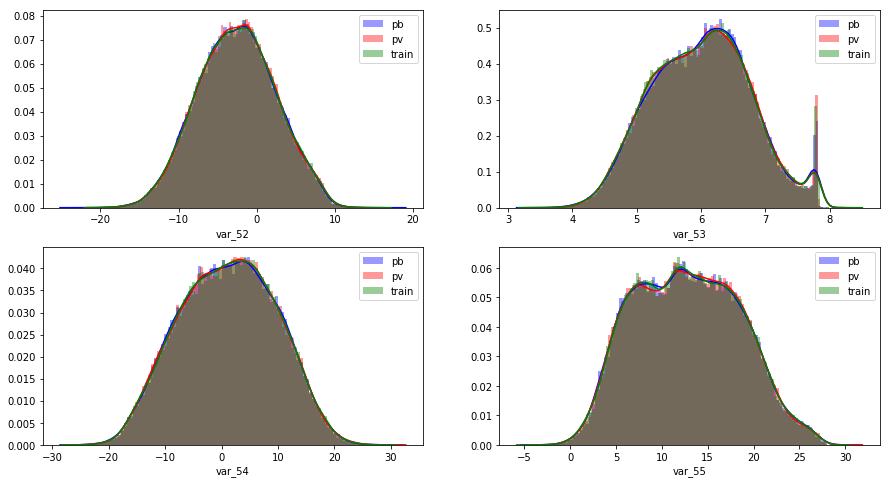

showing var_56 ~ var_59


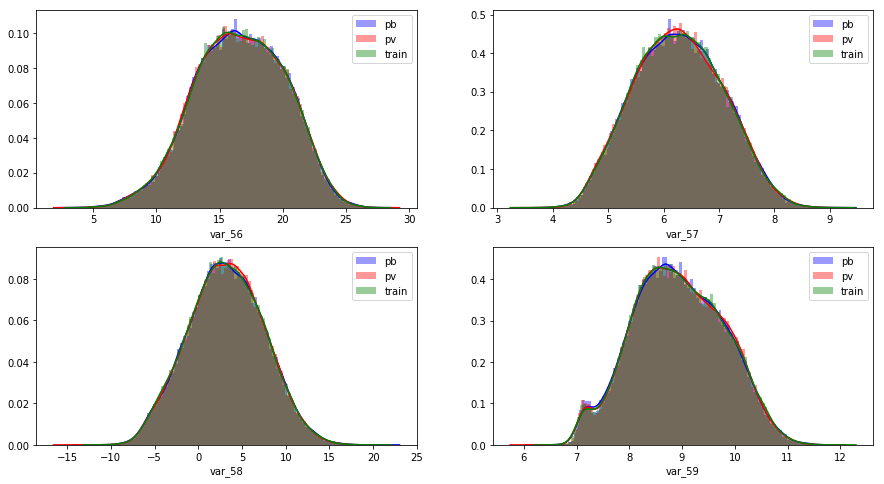

showing var_60 ~ var_63


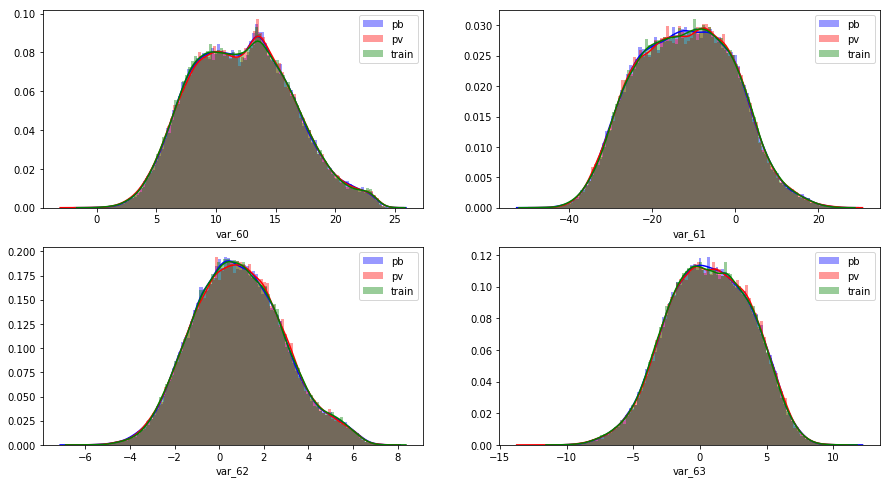

showing var_64 ~ var_67


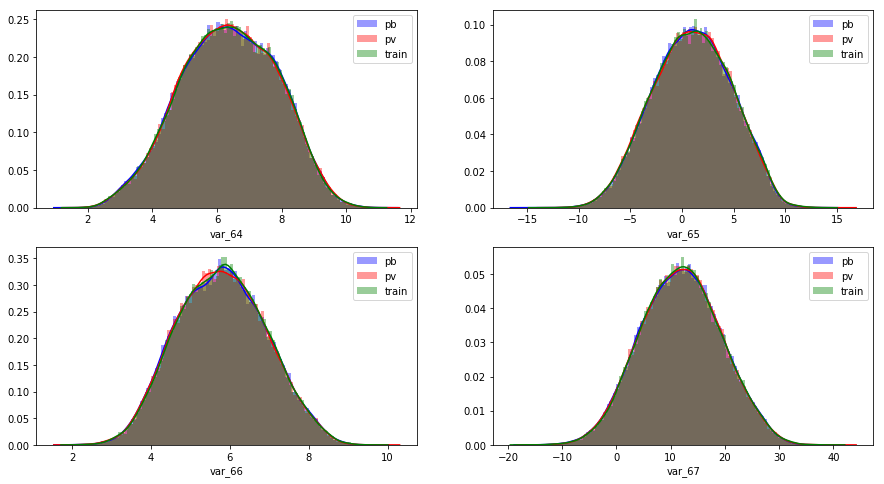

showing var_68 ~ var_71


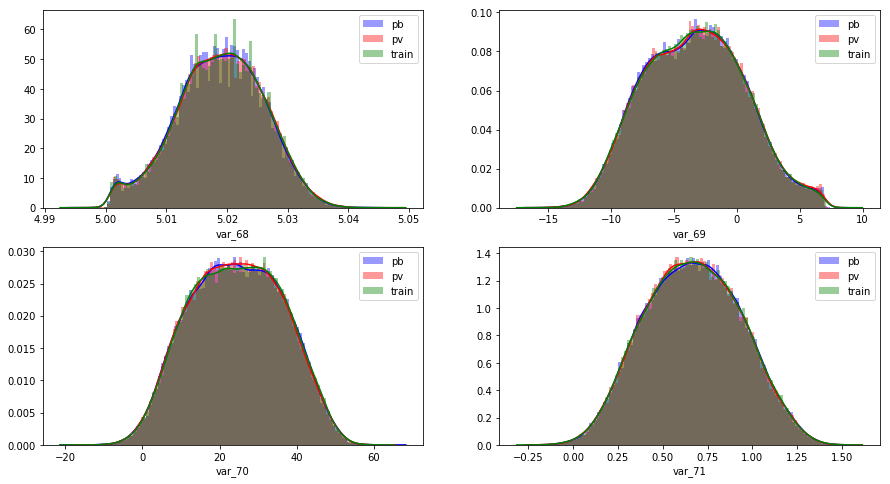

showing var_72 ~ var_75


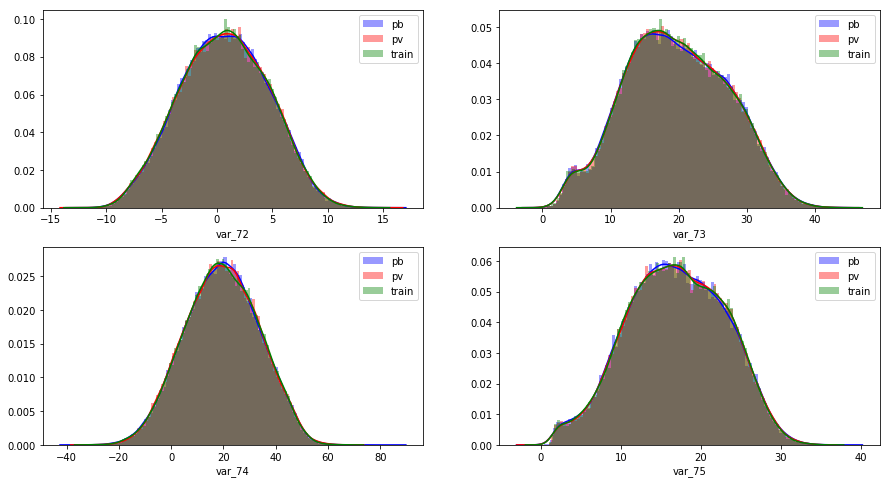

showing var_76 ~ var_79


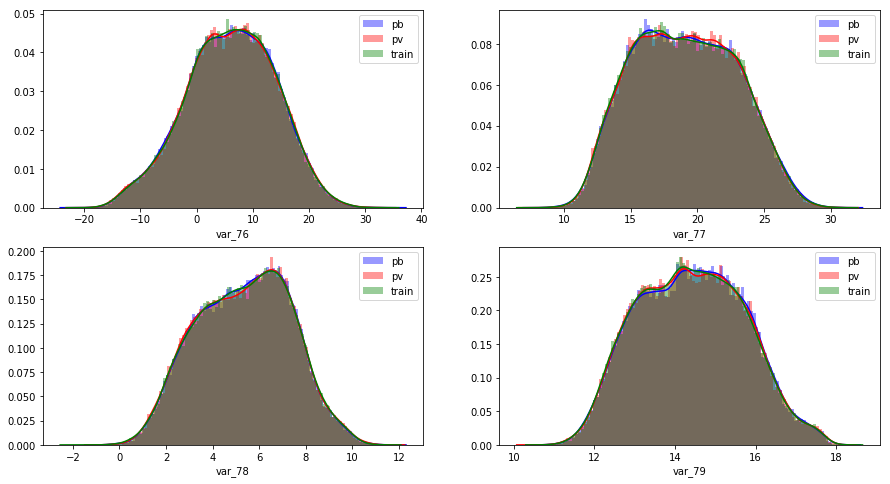

showing var_80 ~ var_83


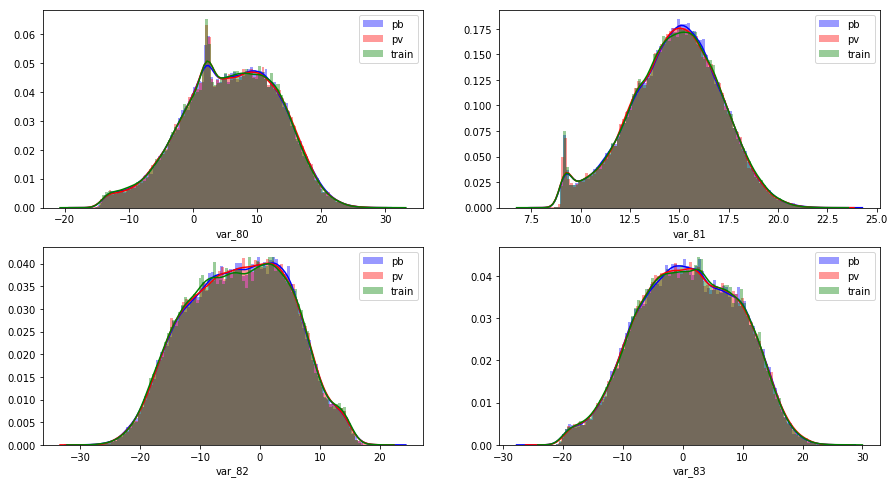

showing var_84 ~ var_87


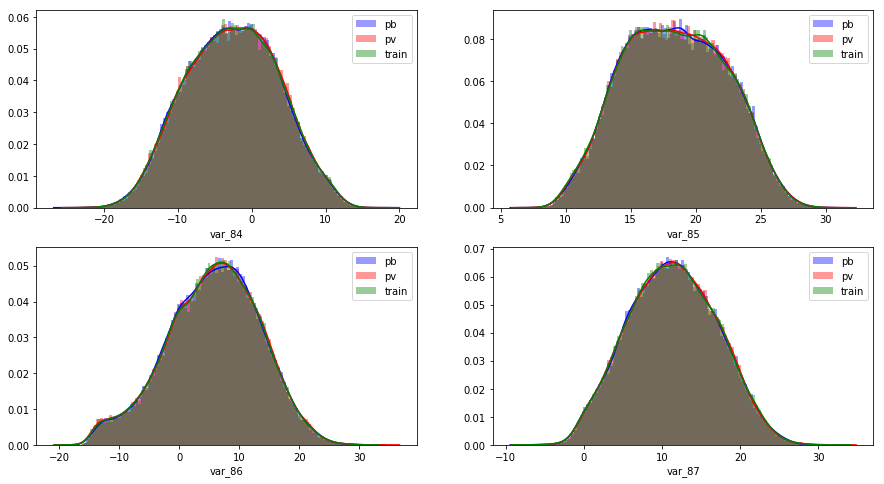

showing var_88 ~ var_91


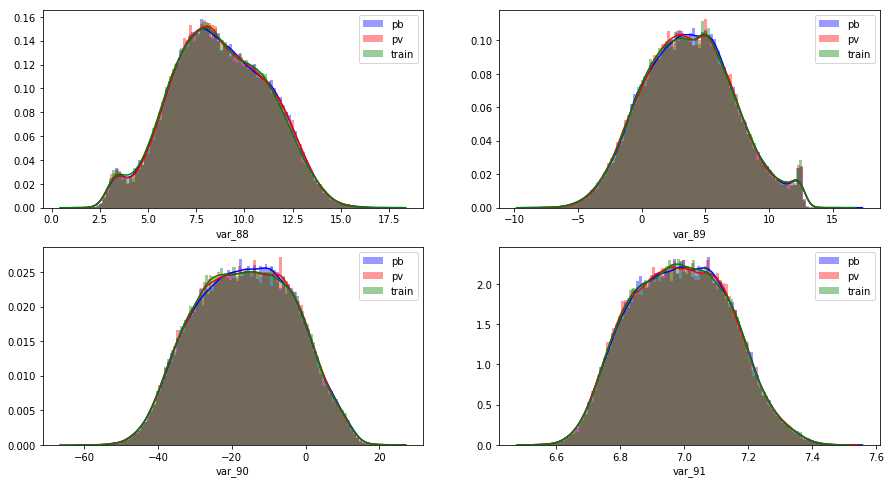

showing var_92 ~ var_95


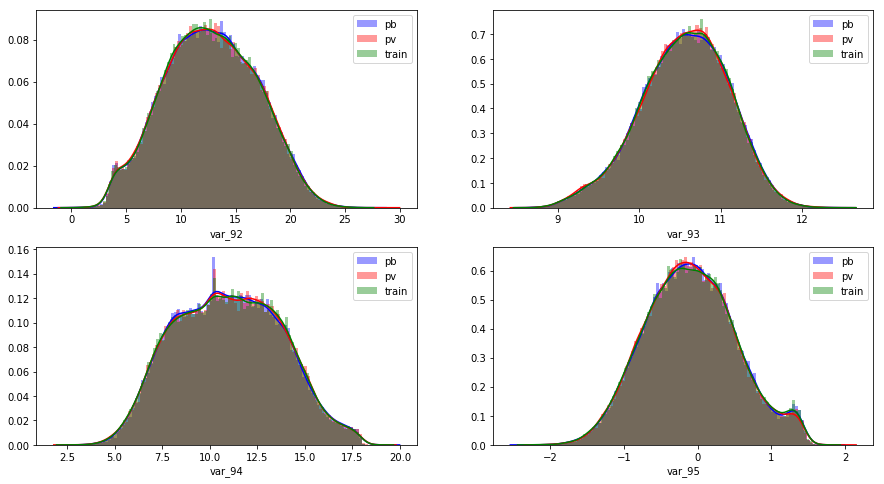

showing var_96 ~ var_99


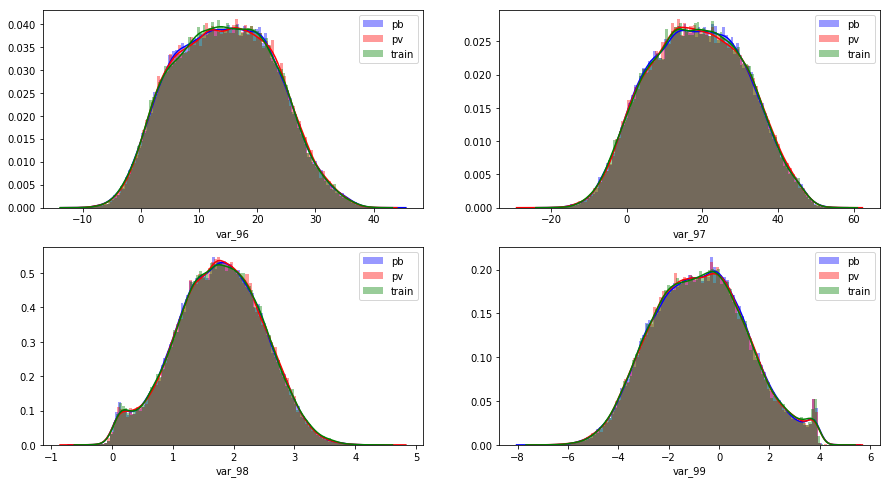

showing var_100 ~ var_103


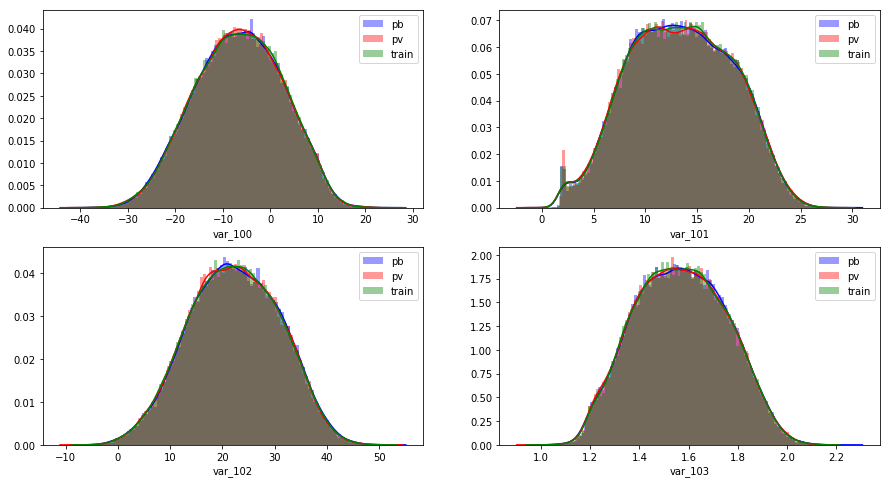

showing var_104 ~ var_107


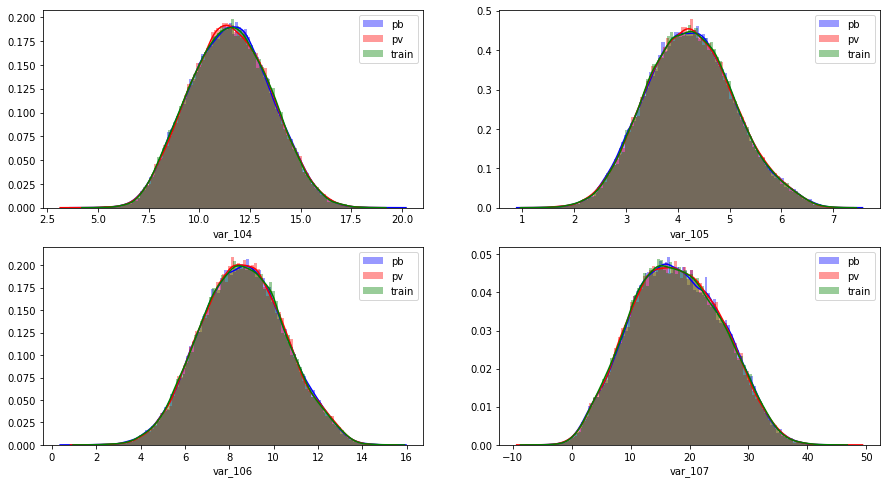

showing var_108 ~ var_111


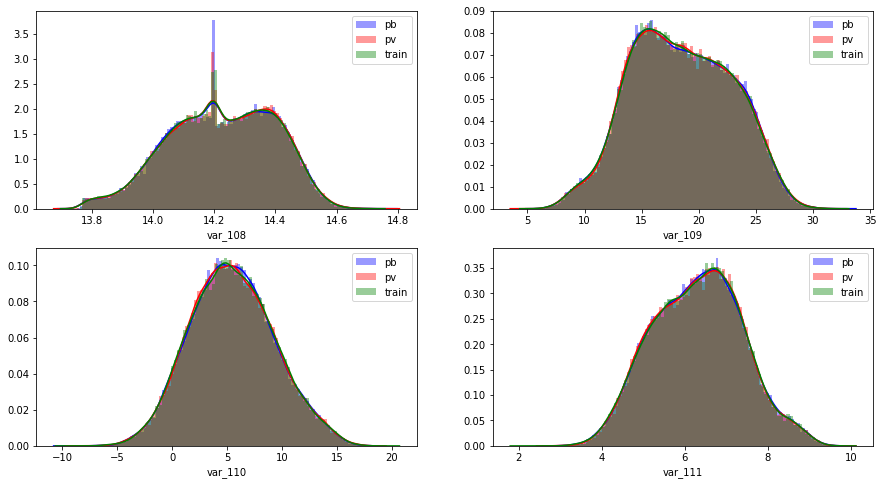

showing var_112 ~ var_115


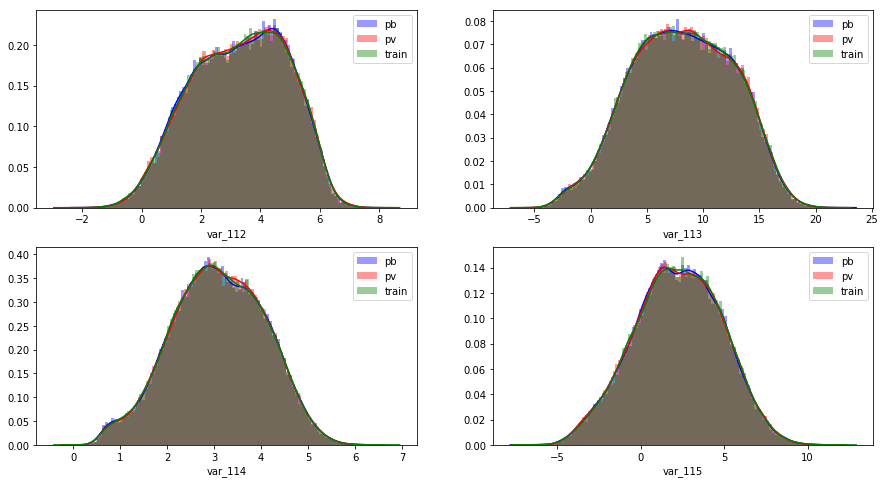

showing var_116 ~ var_119


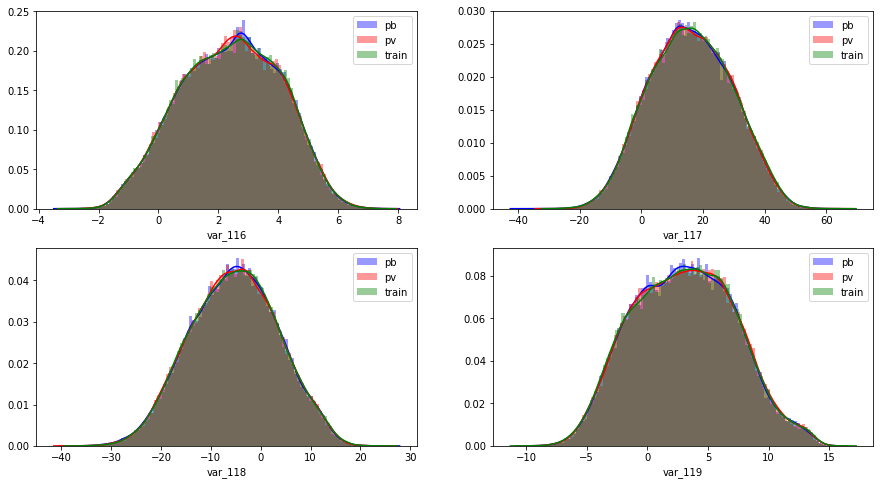

showing var_120 ~ var_123


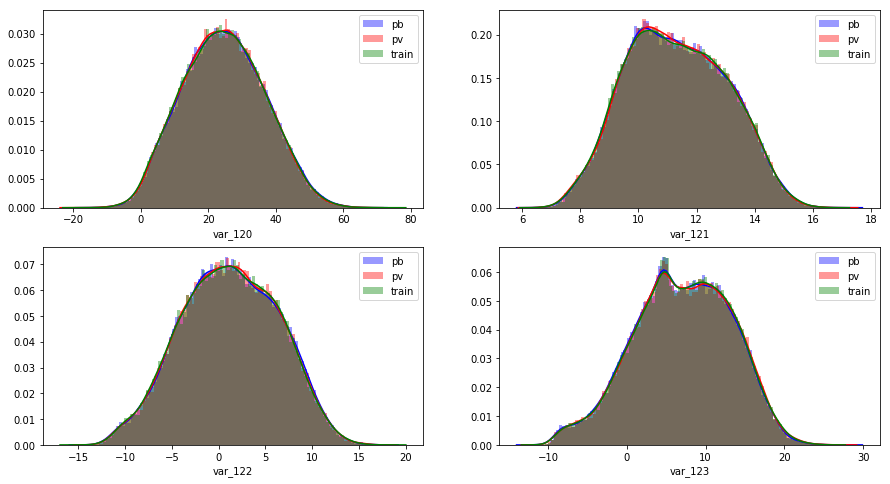

showing var_124 ~ var_127


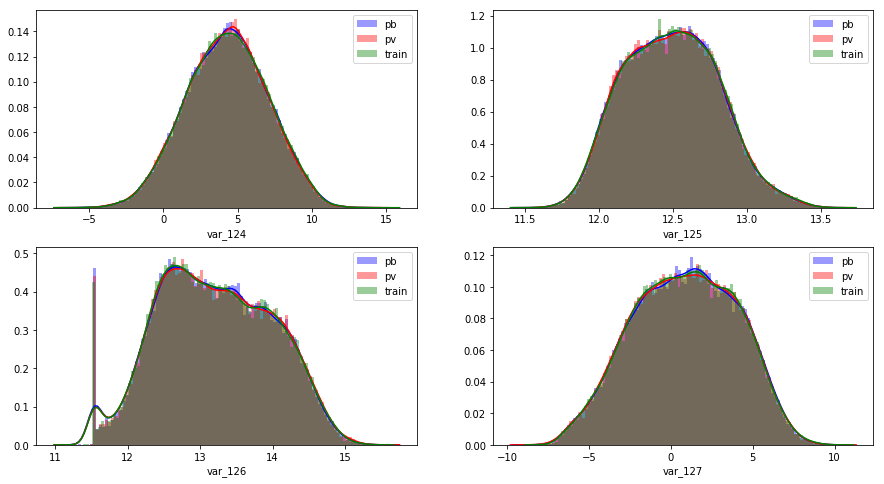

showing var_128 ~ var_131


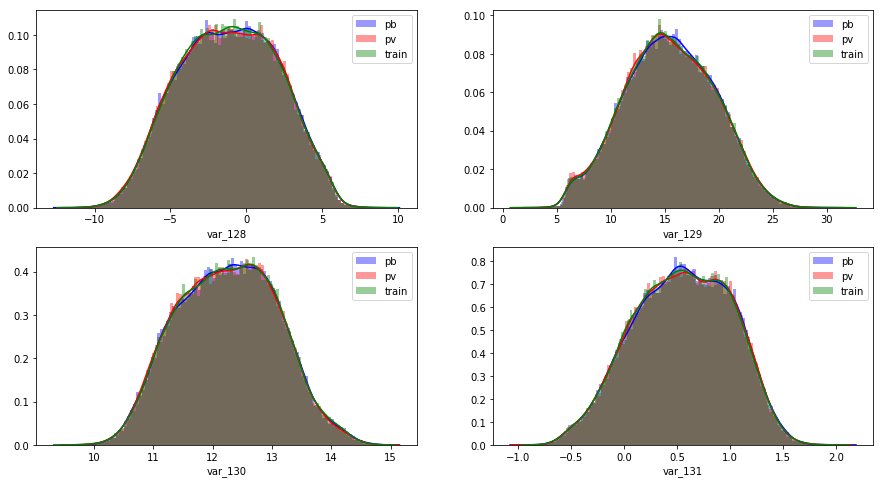

showing var_132 ~ var_135


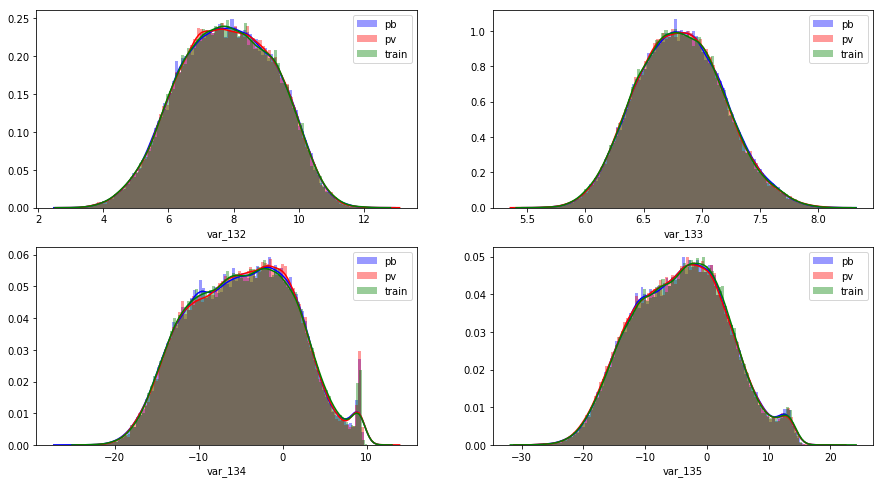

showing var_136 ~ var_139


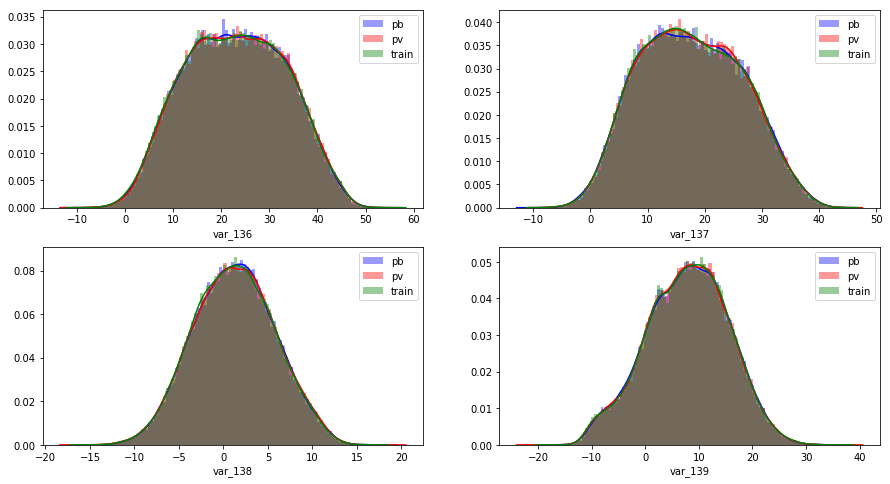

showing var_140 ~ var_143


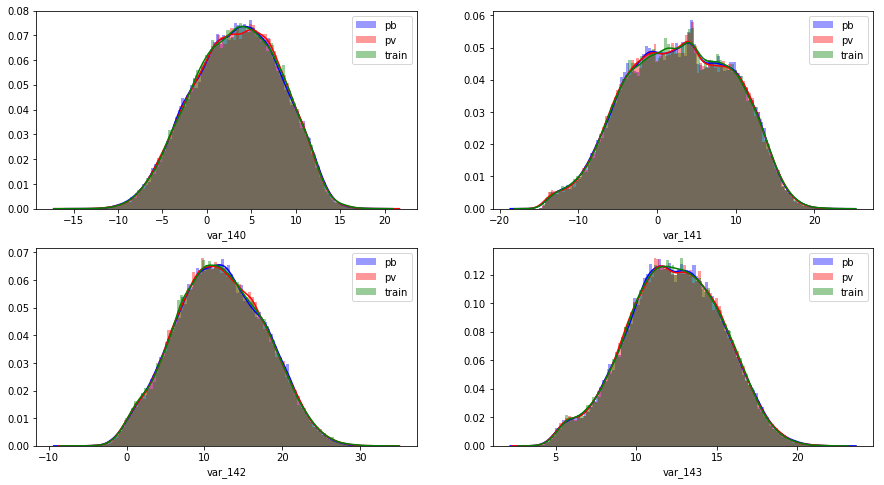

showing var_144 ~ var_147


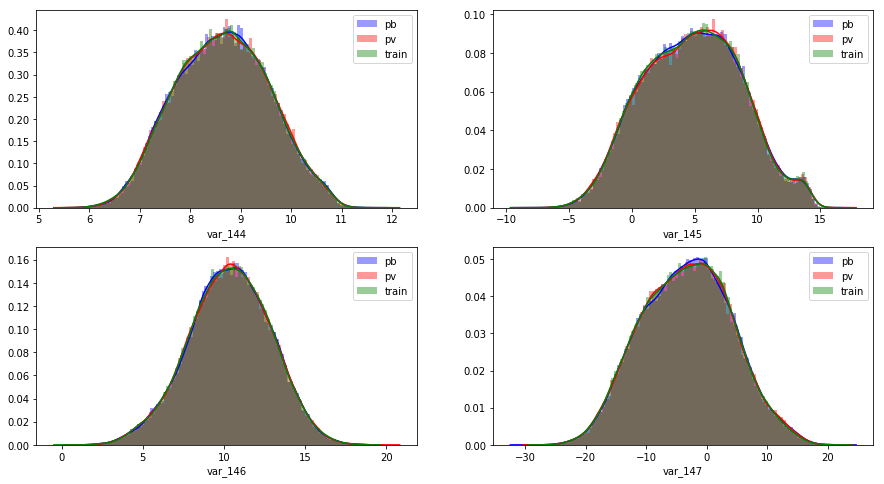

showing var_148 ~ var_151


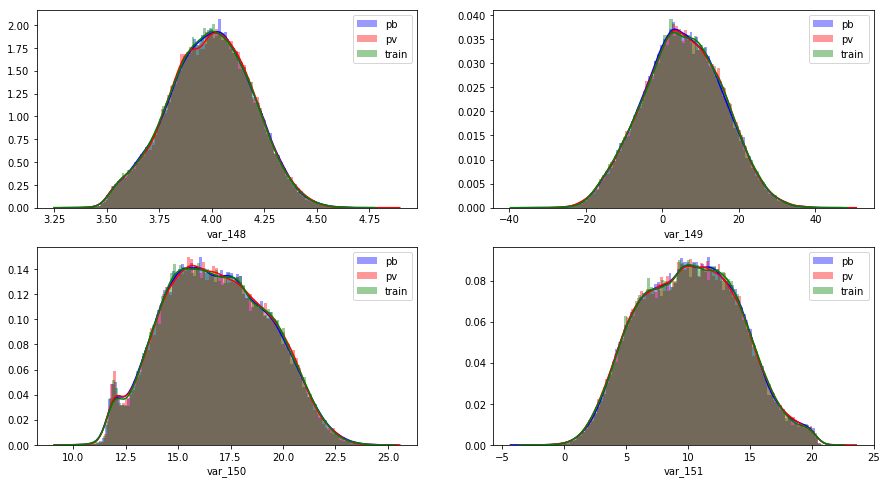

showing var_152 ~ var_155


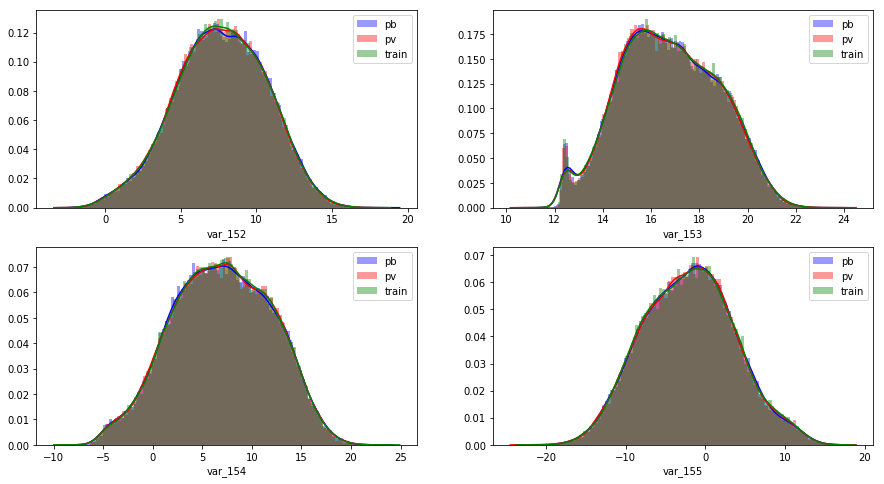

showing var_156 ~ var_159


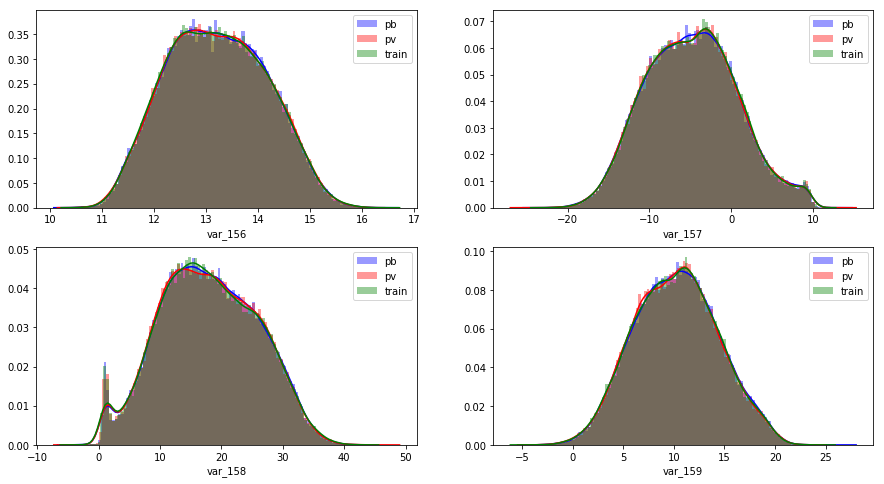

showing var_160 ~ var_163


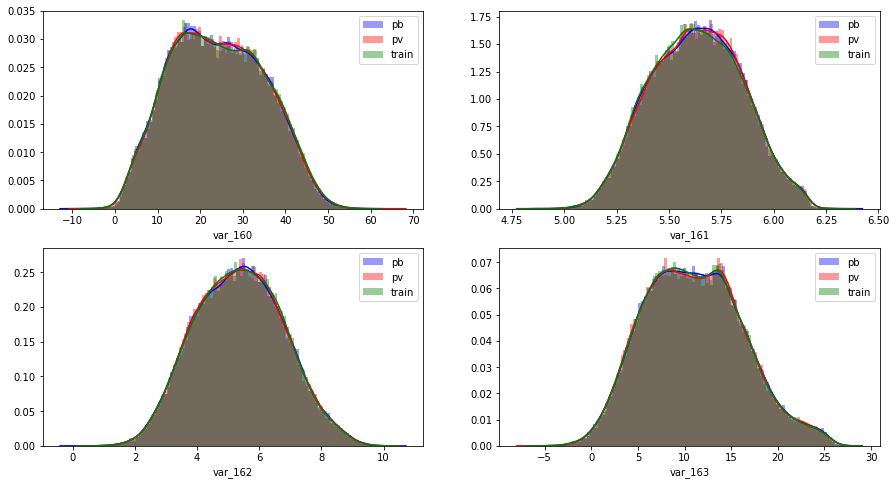

showing var_164 ~ var_167


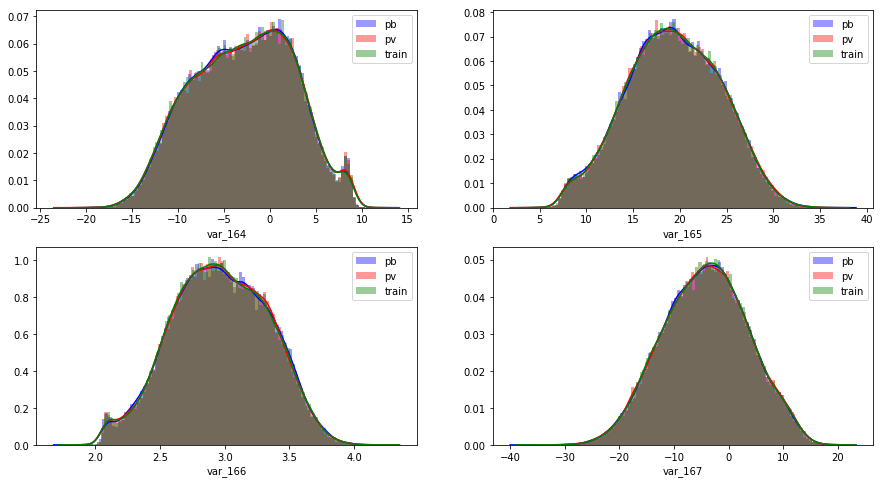

showing var_168 ~ var_171


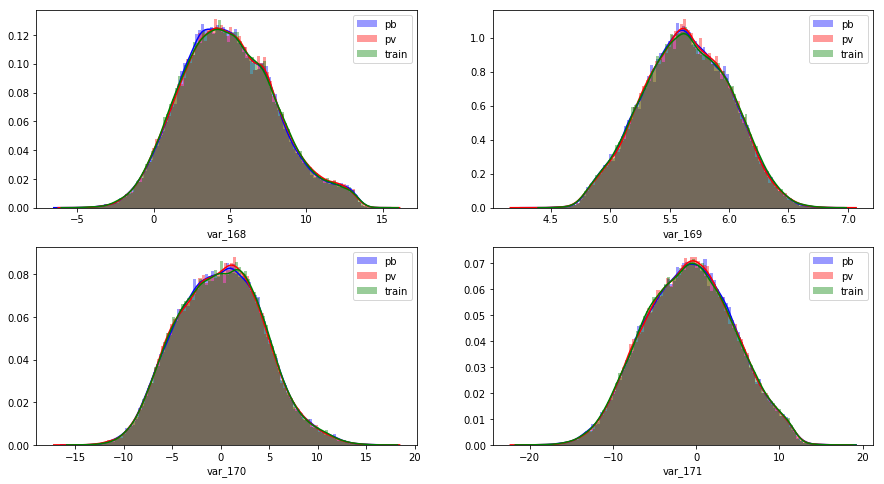

showing var_172 ~ var_175


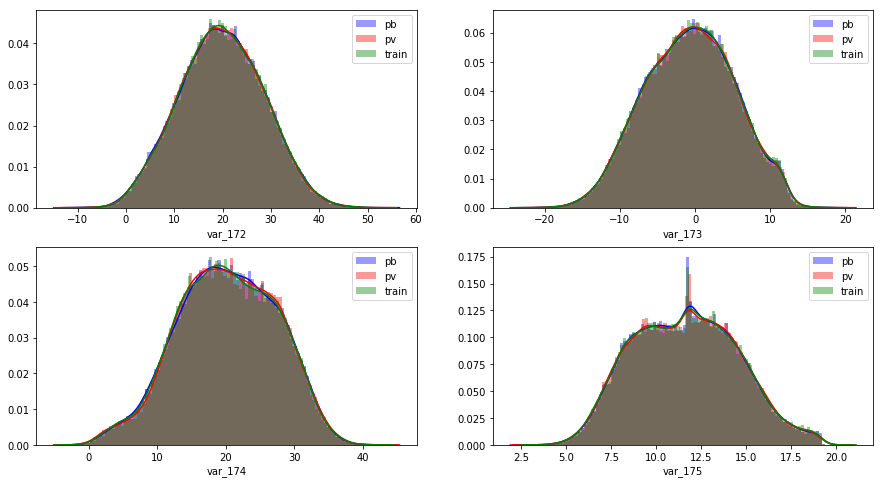

showing var_176 ~ var_179


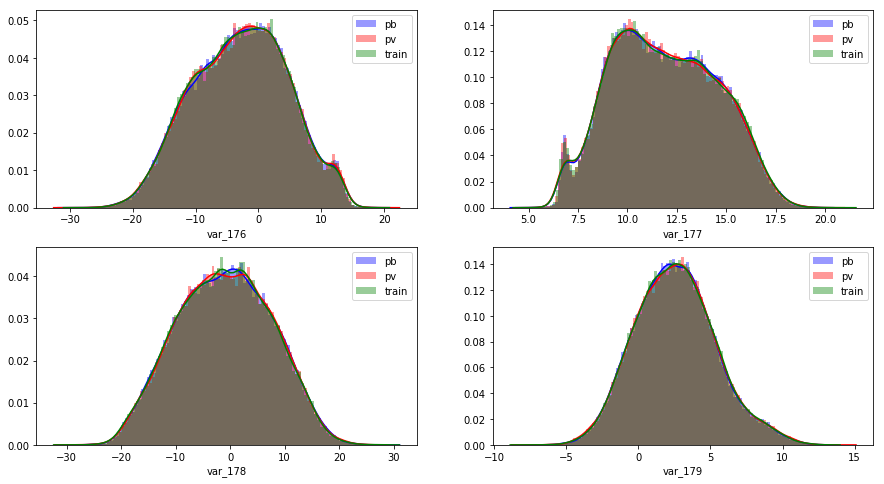

showing var_180 ~ var_183


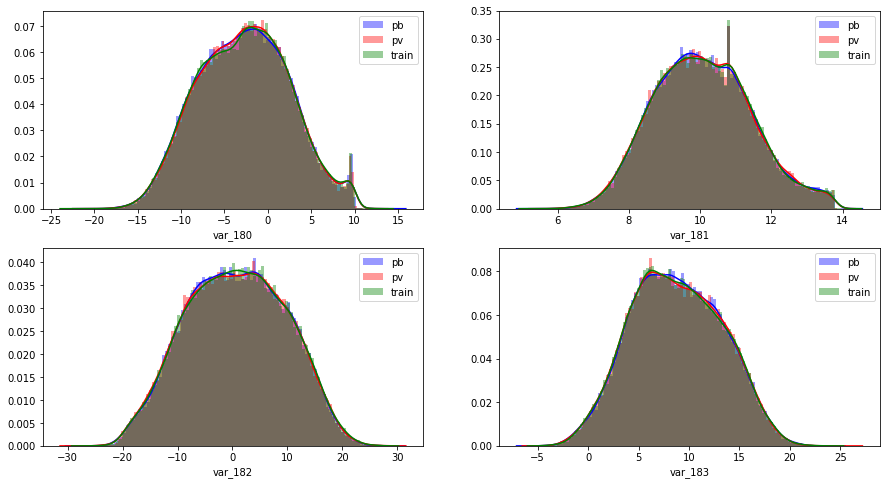

showing var_184 ~ var_187


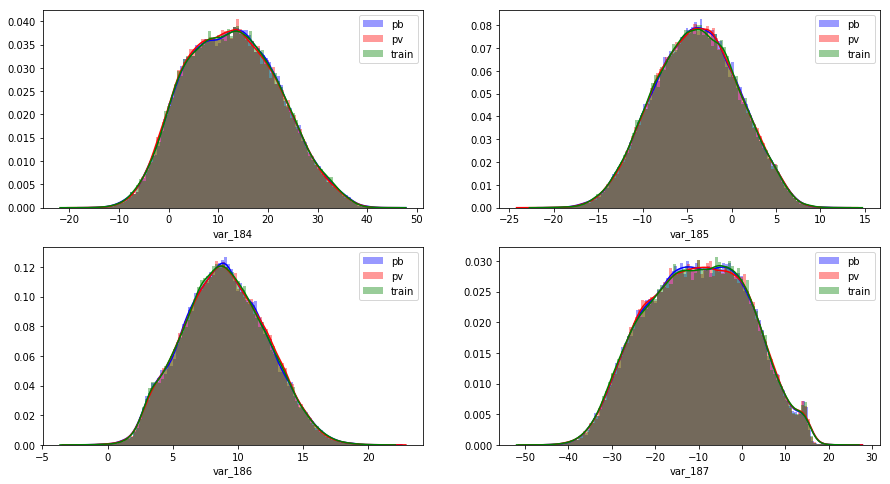

showing var_188 ~ var_191


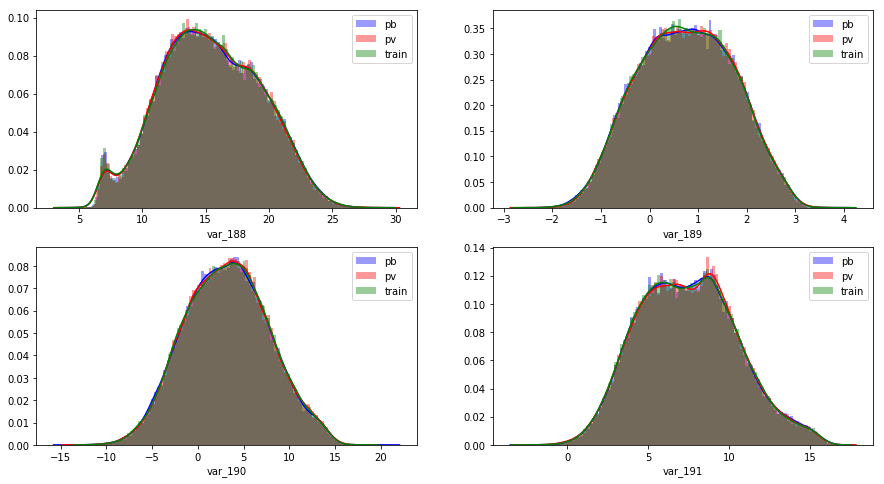

showing var_192 ~ var_195


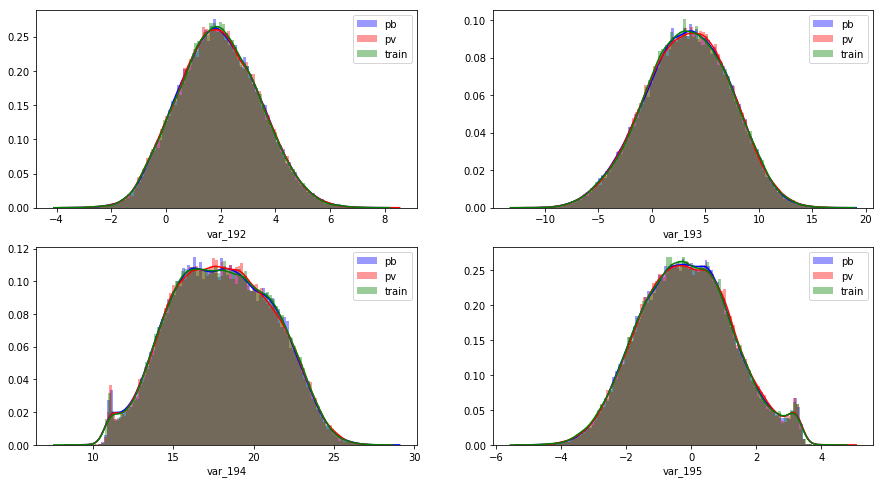

showing var_196 ~ var_199


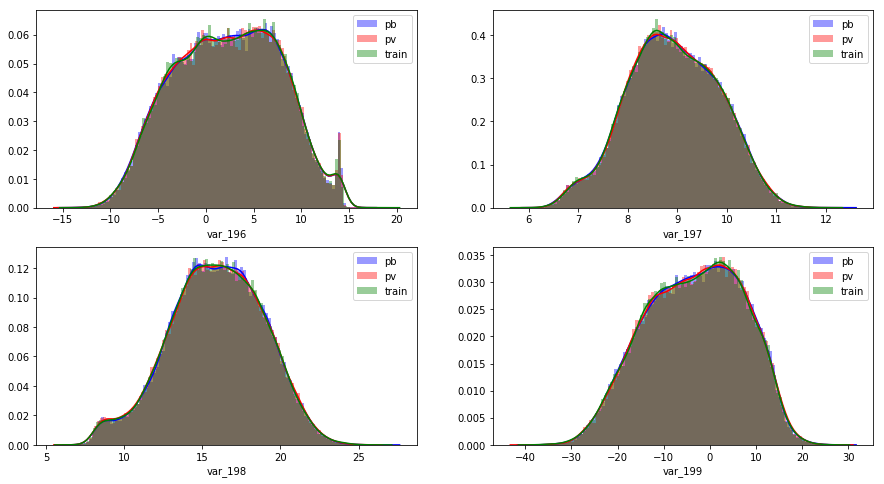

In [18]:
train_temp = train.iloc[:50000].copy()
for i, _ in enumerate(col_list):
    i = i + 1
    if i % 4 != 0:
        continue
    
    print("showing var_{} ~ var_{}".format(i-4, i-1))
    plt.figure(figsize=(15, 8))

    for j, col in enumerate(col_list[i-4:i]):
        j = j + 1
        
        plt.subplot(2, 2, j)
        sns.distplot(test_pb[col], label='pb', color='b', bins=100)
        sns.distplot(test_pv[col], label='pv', color='r', bins=100)
        sns.distplot(train_temp[col], label='train', color='g', bins=100)
        plt.legend()
    plt.show()

In [61]:
# test_pb['target'] = 0
test_pv['target'] = 0
train_temp['target'] = 1

# new_train = test_pb.append(test_pv).sort_index()
# new_train = train_temp.append(test_pb).sort_index()
new_train = train_temp.append(test_pv).sort_index()
target = new_train['target']

In [62]:
param = {
    'bagging_freq': 5,
    'bagging_fraction': 0.335,
    'boost_from_average': False,
    'boost': 'gbdt',
    'feature_fraction_seed': 47,
    'feature_fraction': 0.041,
    'learning_rate': 0.01,
    'max_depth': -1,
    'metric':'auc',
    'min_data_in_leaf': 80,
    'min_sum_hessian_in_leaf': 10.0,
    'num_leaves': 2,
    'num_threads': 8,
    'tree_learner': 'serial',
    'objective': 'binary', 
    'verbosity': 1,
    'num_threads': 8
}

In [63]:
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=8)

oof_lgb = np.zeros(len(new_train))
train_columns = [c for c in new_train.columns if c not in ['ID_code', 'target']]
feature_importance = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(new_train, target.values)):  
    trn_data = lgb.Dataset(new_train.iloc[trn_idx][train_columns], label=target.iloc[trn_idx])
    val_data = lgb.Dataset(new_train.iloc[val_idx][train_columns], label=target.iloc[val_idx])

    num_round = 90000
    clf_new = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=1000, early_stopping_rounds = 200)
    oof_lgb[val_idx] = clf_new.predict(new_train.iloc[val_idx][train_columns], num_iteration=clf_new.best_iteration)
    
    fold_importance = pd.DataFrame()
    fold_importance["Feature"] = train_columns
    fold_importance["importance"] = clf_new.feature_importance()
    fold_importance["fold"] = fold_ + 1
    feature_importance = pd.concat([feature_importance, fold_importance], axis=0)

Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[92]	training's auc: 0.528979	valid_1's auc: 0.500353
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[18]	training's auc: 0.513761	valid_1's auc: 0.513072
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[30]	training's auc: 0.520504	valid_1's auc: 0.509253
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[22]	training's auc: 0.512316	valid_1's auc: 0.50296
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[2]	training's auc: 0.506683	valid_1's auc: 0.504719


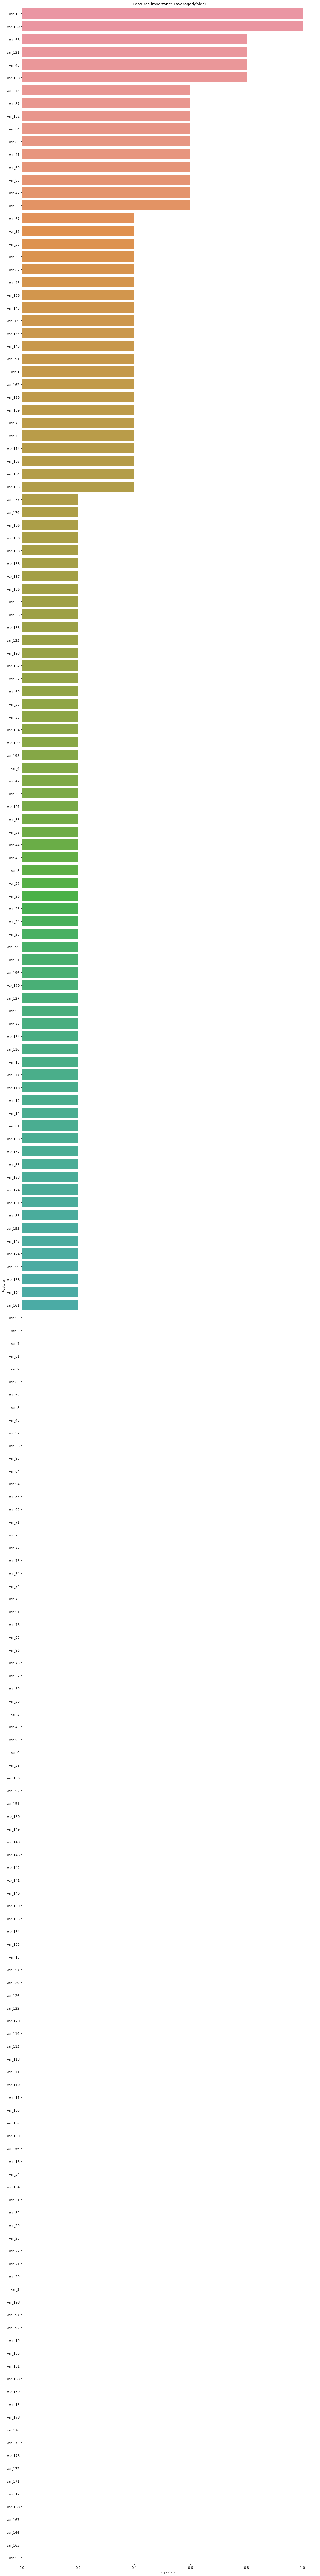

In [64]:
best_features = (feature_importance[["Feature", "importance"]]
                    .groupby("Feature")
                    .mean()
                    .sort_values(by="importance", ascending=False))

plt.figure(figsize=(14,112))
sns.barplot(x="importance", y="Feature", data=best_features.reset_index())
plt.title('Features importance (averaged/folds)')
plt.tight_layout()

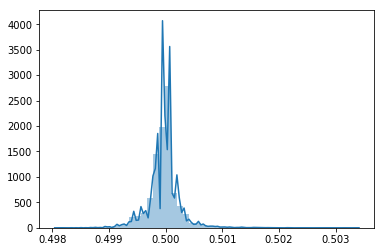

In [29]:
sns.distplot(oof_lgb)

# cv adv pb pv

In [6]:
param = {
    'bagging_freq': 5,
    'bagging_fraction': 0.335,
    'boost_from_average': False,
    'boost': 'gbdt',
    'feature_fraction_seed': 47,
    'feature_fraction': 0.041,
    'learning_rate': 0.01,
    'max_depth': -1,
    'metric':'auc',
    'min_data_in_leaf': 80,
    'min_sum_hessian_in_leaf': 10.0,
    'num_leaves': 2,
    'num_threads': 8,
    'tree_learner': 'serial',
    'objective': 'binary', 
    'verbosity': 1,
    'num_threads': 8
}

In [63]:
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=8)

oof_lgb = np.zeros(len(new_train))
train_columns = [c for c in new_train.columns if c not in ['ID_code', 'target']]
feature_importance = pd.DataFrame()

root = []

for fold_, (trn_idx, val_idx) in enumerate(folds.split(new_train, target.values)):  
    root.append(val_idx)
    trn_data = lgb.Dataset(new_train.iloc[trn_idx][train_columns], label=target.iloc[trn_idx])
    val_data = lgb.Dataset(new_train.iloc[val_idx][train_columns], label=target.iloc[val_idx])

    num_round = 90000
    clf_new = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=1000, early_stopping_rounds = 200)
    oof_lgb[val_idx] = clf_new.predict(new_train.iloc[val_idx][train_columns], num_iteration=clf_new.best_iteration)
    
    fold_importance = pd.DataFrame()
    fold_importance["Feature"] = train_columns
    fold_importance["importance"] = clf_new.feature_importance()
    fold_importance["fold"] = fold_ + 1
    feature_importance = pd.concat([feature_importance, fold_importance], axis=0)

Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[92]	training's auc: 0.528979	valid_1's auc: 0.500353
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[18]	training's auc: 0.513761	valid_1's auc: 0.513072
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[30]	training's auc: 0.520504	valid_1's auc: 0.509253
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[22]	training's auc: 0.512316	valid_1's auc: 0.50296
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[2]	training's auc: 0.506683	valid_1's auc: 0.504719
